### import libraries and other helper functions

In [10]:
#/home/pui_user/PUI2018_msm796/HW4_msm796
#declare libraries
try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib
import datetime
from dateutil.relativedelta import relativedelta #DOWNLOAD THIS PACKAGE#
import os
import requests #DOWNLOAD THIS PACKAGE#
import zipfile #DOWNLOAD THIS PACKAGE#
import io #DOWNLOAD THIS PACKAGE#
import pandas as pd
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import subprocess as sp
import os
import time

#library#
    
#declare parameters
puidata = os.getenv("PUIDATA")
if puidata is None:
    os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
    puidata = os.getenv("PUIDATA")

#declare helper functions
def download_citibike_data(yearstart,yearend,monthstart,monthend,output_path):
    '''
    change log:
    
    version 1.0 - Downloads citibike datasets zip files and unzips them. does checking if file already
    exists in path. currently has no input error handling logic.
    ---------------------------------------------------------------------------------------------
    Parameters:
    name - type - description
    yearstart - <int> - refers to the year where you want your download to start
    yearend - <int> - refers to the year where you want your download to start
    monthstart - <int> - refers to the month ssociated with yearstart where you want your download to start
    monthend - <int> - refers to the month associated with yearend where you want your download to start
    outputpath - <str> - refers to location where you want to dump the csv files
    
    example usage:
    download_citibike_data(2013,2018,6,8,puidata)
    - this downloads the citibike datasets from June 2013 to August 2018. Files will be unzipped at
    the puidata location.
    
    required libraries:
    datautil - required for year & month generation
    requests - for downloading the zip file
    zipfile - to unzip the file
    io - to read binary data and give it to zipfile; effectly keeping the entire process in memory
    '''
    #might include in error handling in the future for incorrect input
    curr_date = start_date=datetime.datetime(yearstart,monthstart,1).date()
    end_date=datetime.datetime(yearend,monthend,1).date()
    year_month=[start_date.strftime('%Y%m')]
    base_citi_url='https://s3.amazonaws.com/tripdata/'
    while curr_date < end_date:
        curr_date += relativedelta(months=1)
        year_month.append(curr_date.strftime('%Y%m'))
    for x in year_month:
    #need to change logic as csv filename convention isn't done properly#
    #will just base on dates found in directory#
        filename=x+"-citibike-tripdata.csv"
        if os.path.isfile(output_path+"/"+filename)==True:
            print("{} already exists!".format(filename))
        else:
            print("Downloading {}".format(filename))
            year=int(x[:4])
            if year>=2017:
                ending=".csv.zip"
            else:
                ending=".zip"
            url=base_citi_url+x+"-citibike-tripdata"+ending
            r = requests.get(url, stream=True)
            z = zipfile.ZipFile(io.BytesIO(r.content))
            z.extractall(output_path)
            
def append_all_citi_bike_data(input_path):
    '''
    developer's notes:
    please refactor me! thanks!
    change log:
    
    version 1.0 -currently has no input error handling logic or checking if file exists.

    Parameters:
    name - type - description
    
    input_path - <str> - location where the csv files are stored
    -Naively appends all files into one superfile
    
    required libraries:
    pandas - the output will be a dataframe, also used to load the files
    '''
    #currently implementing
    files_directory=os.listdir(input_path)
    csv_files = [x for x in files_directory if (".csv" in x) & (("citi" in x) | ("Citi" in x))]
    super_csv = pd.concat([pd.io.parsers.read_csv(input_path+"/"+f,engine='c',memory_map=True,low_memory='dtype') for f in csv_files])
    return super_csv

### I get 2018 August and September citibike datasets

In [4]:
#downloads from beginning to latest available as of late September
download_citibike_data(2018,2018,8,9,puidata)
complete_set=append_all_citi_bike_data(puidata)

201808-citibike-tripdata.csv already exists!
201809-citibike-tripdata.csv already exists!


### Displaying the first five rows of the dataset

In [5]:
complete_set.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,681,2018-08-01 00:00:07.3210,2018-08-01 00:11:28.9920,3162.0,W 78 St & Broadway,40.783400,-73.980931,3383.0,Cathedral Pkwy & Broadway,40.804213,-73.966991,27770,Subscriber,1986,1
1,625,2018-08-01 00:00:19.7480,2018-08-01 00:10:45.0290,3260.0,Mercer St & Bleecker St,40.727064,-73.996621,2012.0,E 27 St & 1 Ave,40.739445,-73.976806,25938,Subscriber,1969,1
2,1319,2018-08-01 00:00:21.1750,2018-08-01 00:22:20.6370,403.0,E 2 St & 2 Ave,40.725029,-73.990697,285.0,Broadway & E 14 St,40.734546,-73.990741,28679,Subscriber,1970,1
3,220,2018-08-01 00:00:26.4700,2018-08-01 00:04:06.8190,3637.0,Fulton St & Waverly Ave,40.683239,-73.965996,399.0,Lafayette Ave & St James Pl,40.688515,-73.964763,28075,Subscriber,1982,1
4,398,2018-08-01 00:00:30.2910,2018-08-01 00:07:09.2810,3662.0,31 Ave & Steinway St,40.761294,-73.916917,3517.0,31 St & Hoyt Ave N,40.771153,-73.917007,25002,Subscriber,1987,1


### For this assignment, i set signifiance level to $\alpha = 0.05$

## 1. Trip duration of bikers that ride during the day vs night

##### for this question, i create a new dataframe with only the necessary columns required to answer this question. In this question we use starttime as our basis for day/night time

In [6]:
drop_cols=[x for x in complete_set.columns.get_values() if x not in ['starttime','tripduration']]
day_night=complete_set.drop(drop_cols,axis=1)

### Displaying the first five rows of the new dataset

In [7]:
day_night.head()

,tripduration,starttime,stoptime
0,681,2018-08-01 00:00:07.3210,2018-08-01 00:11:28.9920
1,625,2018-08-01 00:00:19.7480,2018-08-01 00:10:45.0290
2,1319,2018-08-01 00:00:21.1750,2018-08-01 00:22:20.6370
3,220,2018-08-01 00:00:26.4700,2018-08-01 00:04:06.8190
4,398,2018-08-01 00:00:30.2910,2018-08-01 00:07:09.2810


### Now i create a number of fields that will assist me in my analysis

In [54]:
day_night['start_time_of_day'] = day_night['starttime'].apply(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")).apply(lambda x: x.strftime('%p'))
#day_night['stop_time_of_day'] = day_night['stoptime'].apply(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")).apply(lambda x: x.strftime('%p'))
day_night['start_day'] = day_night['starttime'].apply(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")).apply(lambda x: x.strftime('%-d')).astype(int)
day_night['start_hour'] = day_night['starttime'].apply(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")).apply(lambda x: x.strftime('%-H')).astype(int)
#day_night['stop_hour'] = day_night['stoptime'].apply(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")).apply(lambda x: x.strftime('%-H')).astype(int)
day_night['start_month'] = day_night['starttime'].apply(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")).apply(lambda x: x.strftime('%-m')).astype(int)
#day_night['stop_month'] = day_night['stoptime'].apply(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")).apply(lambda x: x.strftime('%-m')).astype(int)

In [55]:
day_night.head()

,tripduration,starttime,stoptime,start_time_of_day,stop_time_of_day,start_hour,stop_hour,start_month,stop_month,day_v_night_start,day_v_night_stop,start_day
0,681,2018-08-01 00:00:07.3210,2018-08-01 00:11:28.9920,AM,AM,0,0,8,8,Night time,Night time,1
1,625,2018-08-01 00:00:19.7480,2018-08-01 00:10:45.0290,AM,AM,0,0,8,8,Night time,Night time,1
2,1319,2018-08-01 00:00:21.1750,2018-08-01 00:22:20.6370,AM,AM,0,0,8,8,Night time,Night time,1
3,220,2018-08-01 00:00:26.4700,2018-08-01 00:04:06.8190,AM,AM,0,0,8,8,Night time,Night time,1
4,398,2018-08-01 00:00:30.2910,2018-08-01 00:07:09.2810,AM,AM,0,0,8,8,Night time,Night time,1


### Since the question is asking if there is a difference between day time and night time, i have to set a rule that differentiates the time of the day. I will base this on the sunrise and sunset back in 2016 August and 2016 September. However as a limitation, i will arbitarily base the threshold for dates from observed values and assume these events happen at the start of a particular hour.

https://www.timeanddate.com/sun/usa/new-york?month=8&year=2016

<b>For August 2016</b>, <br> Sunrise: 6:00 <br> Sunset: 20:00 <br>
Thus Day time: 6:00 - 19:59, and Night time: 20:00 - 5:59 <br>
<b>For September 2016</b>, <br>Sunrise: 6:00 <br>  Sunset: 19:00 <br>
Thus Day time: 6:00 - 18:59, and Night time: 19:00 - 5:59 

In [49]:
cond01=6<=day_night['start_hour']
cond02=6<=day_night['start_hour']
#cond03=6<=day_night['stop_hour']
#cond04=6<=day_night['stop_hour']
cond1=day_night['start_hour']<20
cond2=day_night['start_hour']<19
#cond3=day_night['stop_hour']<20
#cond4=day_night['stop_hour']<19
cond5=day_night['start_month']==8 
cond6=day_night['start_month']==9
#cond7=day_night['stop_month']==8 
#cond8=day_night['stop_month']==9

day_night['day_v_night_start'] = np.where(
                                        np.logical_or(
                                        np.logical_and( cond5, np.logical_and(cond01, cond1) ),
                                        np.logical_and( cond6, np.logical_and(cond02, cond2) )
                                                      ),'Day time', 'Night time')
#day_night['day_v_night_stop'] = np.where(
#                                        np.logical_or(
#                                        np.logical_and( cond7, np.logical_and(cond03, cond3) ),
#                                        np.logical_and( cond8, np.logical_and(cond04, cond4) )
#                                                      ),'Day time', 'Night time')

### We now seperate the dataset based on their subgrouping and compare their distribution. We also drop rows with NA duration should there exists.

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


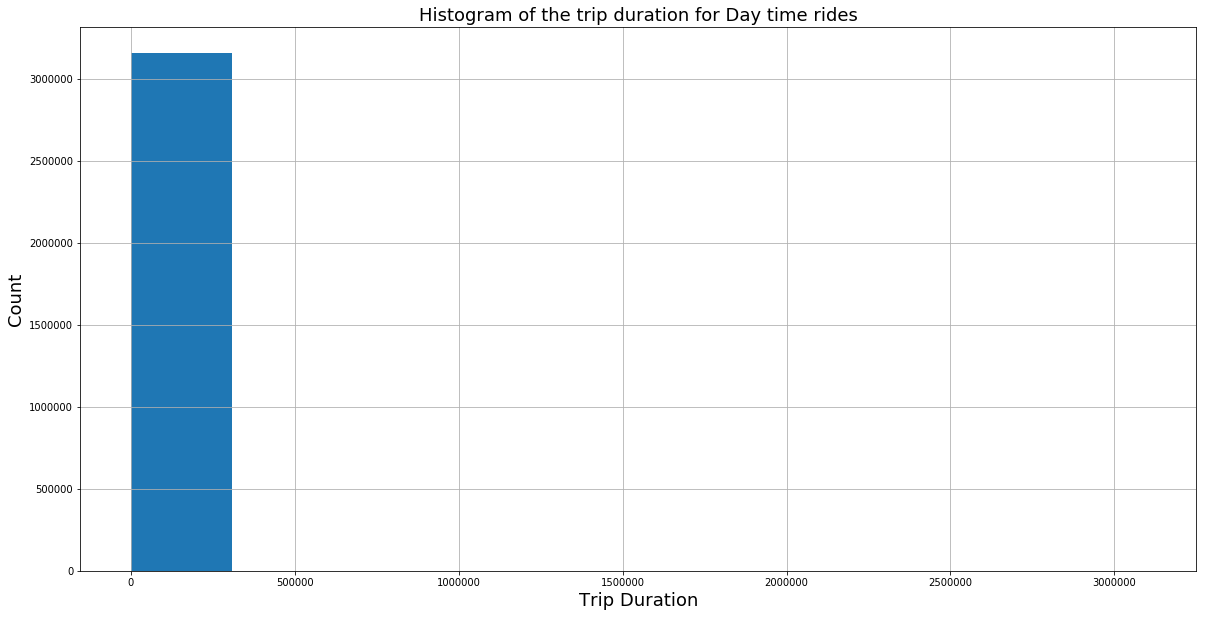

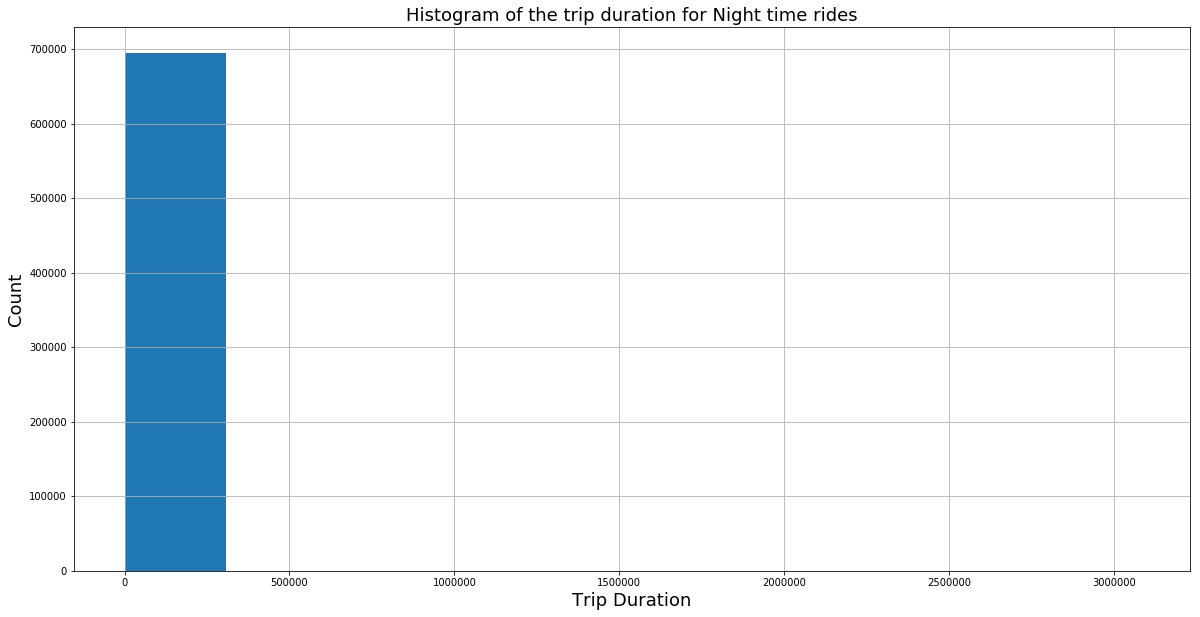

In [66]:
day_ = day_night[(day_night['day_v_night_start']=='Day time')]
night_ = day_night[(day_night['day_v_night_start']=='Night time')]

day_.dropna(inplace=True)
night_.dropna(inplace=True)

#day time
day_.hist('tripduration',bins=10,figsize=(20,10))
plt.xlabel("Trip Duration",fontsize=18)
plt.ylabel("Count",fontsize=18)
plt.title("Histogram of the trip duration for Day time rides",fontsize=18)

#night time
night_.hist('tripduration',bins=10,figsize=(20,10))
plt.xlabel("Trip Duration",fontsize=18)
plt.ylabel("Count",fontsize=18)
plt.title("Histogram of the trip duration for Night time rides",fontsize=18)

plt.show()

### Figure 1 & 2: The histogram of the trip duration of both Day and Night time Ride. I had left the binning to automatic and we get a visualization that should hint for heavy outliers affecting our graph.

### Our next interest would be looking into their respective summary statistics

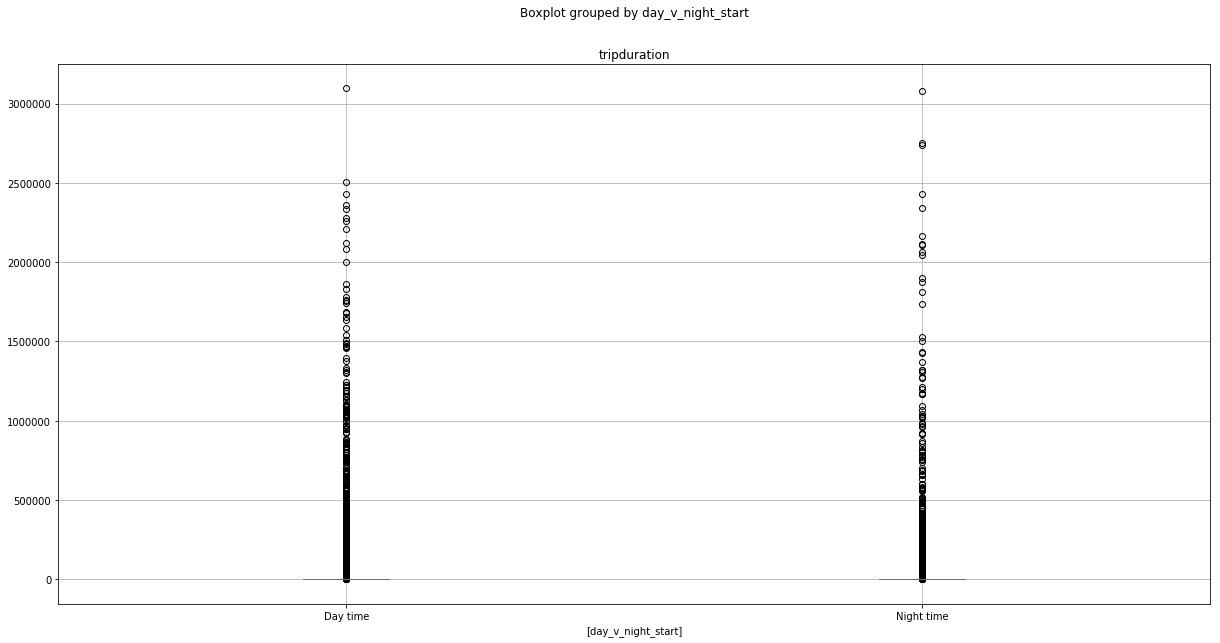

In [108]:
day_night[['tripduration','day_v_night_start']].boxplot(by='day_v_night_start', figsize=(20,10)
plt.xlabel()
plt.ylabel()
plt.title()                                                                                                                

### Figure 3: Box plot of our trip duration. The graph doesn't even show a box due to the vast counts of outliers. As shown by the black circles.

In [112]:
centiles = np.arange(0, 1, 0.25)
print(centiles)

results_day = day_.tripduration.quantile(centiles)
results_night = night_.tripduration.quantile(centiles)

print("quantile of daytime: \n{}".format(results_day))
print("\n")
print("quantile of nighttime: \n{}".format(results_night))

[ 0.    0.25  0.5   0.75]
quantile of daytime: 
0.00      61.0
0.25     377.0
0.50     644.0
0.75    1138.0
Name: tripduration, dtype: float64


quantile of nighttime: 
0.00      61.0
0.25     363.0
0.50     624.0
0.75    1092.0
Name: tripduration, dtype: float64


[ 0.95    0.9515  0.953   0.9545  0.956   0.9575  0.959   0.9605  0.962
  0.9635  0.965   0.9665  0.968   0.9695  0.971   0.9725  0.974   0.9755
  0.977   0.9785  0.98    0.9815  0.983   0.9845  0.986   0.9875  0.989
  0.9905  0.992   0.9935  0.995   0.9965  0.998   0.9995]


Text(0.5,1,'Percentile distribution of counts for Night time rides')

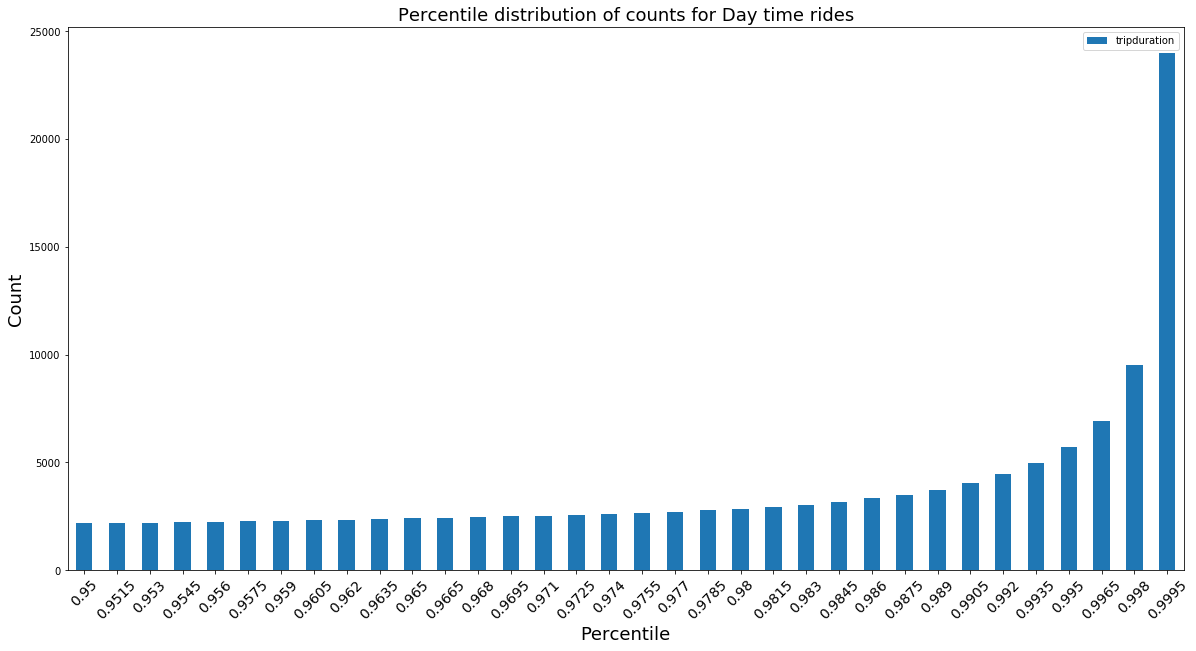

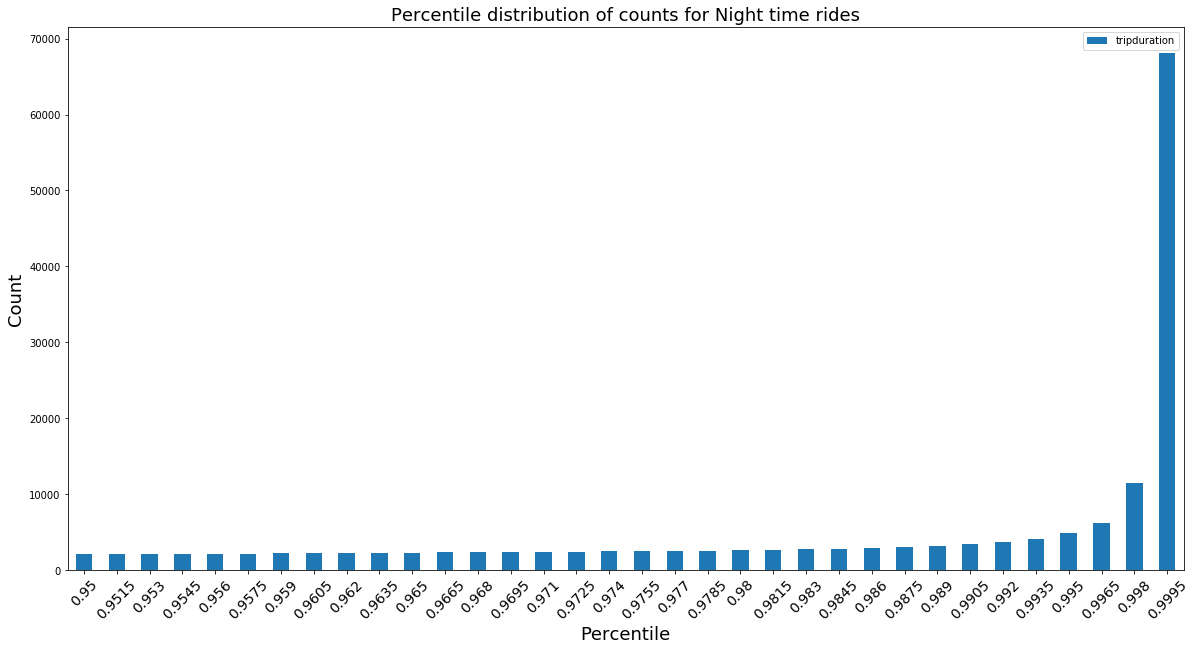

In [131]:
centiles = np.arange(0.95, 1, 0.0015)
print(centiles)

results_day = pd.DataFrame(day_.tripduration.quantile(centiles)).plot(kind='bar',figsize=(20,10),rot=45)
#plt.xticks(np.arange(0.95, 1, 0.0015),fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Percentile",fontsize=18)
plt.ylabel("Count",fontsize=18)
plt.title("Percentile distribution of counts for Day time rides",fontsize=18)

results_night = pd.DataFrame(night_.tripduration.quantile(centiles)).plot(kind='bar',figsize=(20,10),rot=45)
#plt.xticks(np.arange(0.95, 1, 0.0015),fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Percentile",fontsize=18)
plt.ylabel("Count",fontsize=18)
plt.title("Percentile distribution of counts for Night time rides",fontsize=18)


#print("quantile of daytime: \n{}".format(results_day))
#print("\n")
#print("quantile of nighttime: \n{}".format(results_night))

### Figure 4 & 5: the percentile distribution from the 95th percentile, and onwards. From this visualization, we can determine where most outliers are concentrated. 